# Rigol Scope Reader

Based on the following projects:

 * Download data from a Rigol DS1052E oscilloscope and graph with matplotlib.
By Ken Shirriff, http://righto.com/rigol

 * http://www.cibomahto.com/2010/04/controlling-a-rigol-oscilloscope-using-linux-and-python/
By Cibo Mahto.

 * https://gist.github.com/samclane/c0fb90219214361cb963674b3bc82848
By Sawyer McLane

Rigol oscilloscope programming guides  
 * https://www.batronix.com/pdf/Rigol/ProgrammingGuide/DS1000DE_ProgrammingGuide_EN.pdf
 * https://www.batronix.com/files/Rigol/Oszilloskope/_DS&MSO1000Z/MSO_DS1000Z_ProgrammingGuide_EN.pdf

In [5]:
# %matplotlib widget
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import sys
import pyvisa as visa
import time

In [6]:
## list available instruments
rm = visa.ResourceManager()
instruments = rm.list_resources()
devs = list(filter(lambda x: 'USB' in x, instruments))
print('Instrument list:', instruments)

Instrument list: ('USB0::0x1AB1::0x04CE::DS1ZA193515618::INSTR', 'ASRL1::INSTR', 'ASRL3::INSTR', 'GPIB0::22::INSTR', 'USB0::0x1AB1::0x04CE::DS1ZA171509582::0::INSTR')


In [7]:
"""Get the VISA instrument and query it"""

# the instrument name as found in NI MAX or in the list above
NAME = 'USB0::0x1AB1::0x04CE::DS1ZA193515618::INSTR'

# create a VISA reference to the scope and get data
rm = visa.ResourceManager()
scope = rm.open_resource(NAME, timeout=20, chunk_size=1024000)
scope.timeout = 1000 # in seconds?



# Grab the raw data from channel 1
# scope.write(":STOP")

# Get the timescale
timescale = float(scope.query(":TIM:SCAL?"))
print(f"timescale: {timescale} [s]")

# Get the timescale offset
timeoffset = float(scope.query(":TIM:OFFS?")[0])
print(f"time offset: {timeoffset} [s]")

# Volt scale
voltscale = float(scope.query(':CHAN1:SCAL?')[0])
print(f"volt scale: {voltscale} [V]")

# And the voltage offset
voltoffset = float(scope.query(":CHAN1:OFFS?")[0])
print(f"time offset: {voltoffset} [V]")

# Configure data retrieval and take a data sample
scope.write(":WAV:FORM ASC")
scope.write(":WAV:POIN:MODE NORM") # NORM instead of RAW, which takes the whole buffer
# scope.write(":WAV:STAR 1")
# scope.write(":WAV:STOP 10")
rawdata = scope.query(":WAV:DATA? CHAN1").encode('ascii')

data_size = len(rawdata)

# this always times out. might not be a valid command for this scope.
# sample_rate = scope.query(':ACQ:SAMP?')[0]
print('Data size:', data_size)#, "Sample rate:", sample_rate)

timescale: 0.001 [s]
time offset: 0.0 [s]
volt scale: 1.0 [V]
time offset: 0.0 [V]


VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

In [ ]:
# Channel labels and colors

colors=['yellow','cyan','magenta','blue']#[:2] # channel colors
channels=['CHAN1','CHAN2','CHAN3','CHAN4']#[:2] # names for commands

# Query the scope once to get the data length
rawdata = scope.query(":WAV:DATA? CHAN1").encode('ascii')
data_size = len(rawdata)

t_pts = np.linspace(timeoffset - 6 * timescale, 
                       timeoffset + 6 * timescale, 
                       num=data_size)

# See if we should use a different time axis
if (t_pts[-1] < 1e-3):
    t_scl = 1e6
    tUnit = r"$\mu s$"
elif (t_pts[-1] < 1):
    t_scl = 1e3
    tUnit = "ms"
else:
    t_scl = 1
    tUnit = "s"

# voltage scaling function
voffset = 130
vscale = 25
scale_data = lambda x: (-1*(x - voffset - voltoffset/voltscale*vscale) 
                        / vscale * voltscale + 255)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,100):
# while True:
    time.sleep(.001)

    # query scope
    for ch in channels:
        if ch == 'CHAN1':
            scope.write(":WAV:SOUR CHAN1") # Grab the data from channel 1            
            data_matrix = np.array([
                np.fromstring(scope.query(f":WAV:DATA? CHAN1")[11:],sep=',')])
                #The first 11 characters are a header and should be discarded
        else:
            scope.write(f":WAV:SOUR {ch}")
            data_matrix = np.vstack((data_matrix,np.array([
                np.fromstring(scope.query(f":WAV:DATA? {ch}")[11:],sep=',')])))
            
    t_pts = np.linspace(timeoffset - 6 * timescale, 
                       timeoffset + 6 * timescale, 
                       num=len(data_matrix[0]))*t_scl
    
    # update the plot
    ax.clear()
    for data, color, chan in zip(data_matrix, colors, channels):
        ax.plot(t_pts, data, c=color, label=chan)#, label=channels, color=colors)
    ax.set_xlabel(f'time [{tUnit}]')
    ax.set_ylabel("volts")
    ax.legend()
    fig.canvas.draw()

plt.close()

In [4]:
scope.write(":KEY:FORCE")
scope.close()

## misc. testing

<IPython.core.display.Javascript object>


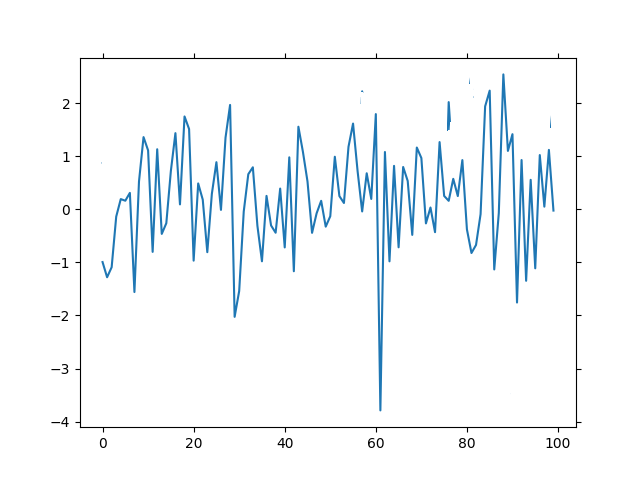

In [70]:
# dynamic plot example

m = 100
n = 100
matrix = np.random.normal(0,1,m*n).reshape(m,n)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,100):
    ax.clear()
    ax.plot(matrix[i,:])
    fig.canvas.draw()